# Baseball Data: a thorough analysis 
#### A data set containing complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. 

#### the data is available at: http://www.seanlahman.com/baseball-archive/statistics/

### Focus of our analysis
#### Our analysis will focus on players salaries:
- What is the salary evolution between 1871 and 2014?
- Were different teams awarded different salaries?
    - were the difference justified?
- Did awarded players earn more on average?
- What was the influence of appearances on salary?
- Did the college attended influence salary of players?
- Were the players with the best statistics awarded the with the best salaries?

### Packages needed

In [6]:
# Import General Packages
import numpy as np
import pandas as pd

# Import plotting/graphics packages
import matplotlib.pyplot as plt
import seaborn as sns 

# Graphics inline 
%matplotlib inline

### Importing the datasets of interest 

Main tables:
- MASTER - Player names, DOB, and biographical info
- Batting - batting statistics
- Pitching - pitching statistics
- Fielding - fielding statistics


Supplemented by theses tables 
- Teams - yearly stats and standings 
- Salaries - player salary data
- AwardsPlayers - awards won by players
- AwardsSharePlayers - award voting for player awards
- Appearances - details on the positions a player appeared at
- Schools - list of colleges that players attended
- CollegePlaying - list of players and the colleges they attended

In [23]:
master = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
batting = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
pitching = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')
fielding = pd.read_csv('baseballdatabank-2017.1/core/Fielding.csv')
teams = pd.read_csv('baseballdatabank-2017.1/core/Teams.csv')
salaries = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
awardPlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsPlayers.csv')
awardsSharePlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsSharePlayers.csv')
appearances = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
schools = pd.read_csv('baseballdatabank-2017.1/core/Schools.csv')
collegePlaying = pd.read_csv('baseballdatabank-2017.1/core/CollegePlaying.csv')

# Salary evolution

In [33]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


In [34]:
salaries.lgID.unique()

array(['NL', 'AL'], dtype=object)

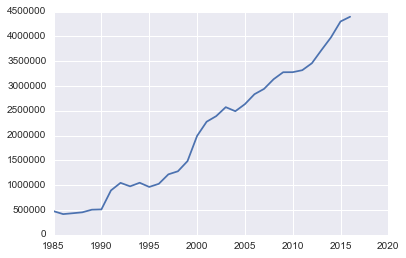

In [32]:
plt.plot(salaries.groupby(['yearID']).mean()['salary'])